# Group N — Python Performance with and without NumPy

This Jupyter Notebook integrates **code**, **results**, and **commentary** for Programming Assignment 1: **Python Performance with and without NumPy**.

## What this notebook does
- Benchmarks **Pure Python** vs **NumPy** for:
  - 1-D **element-wise vector multiplication**
  - 2-D **true matrix multiplication** (triple nested loops for the pure-Python version)
- Follows the required measurement protocol:
  - Fixed random seed
  - Create arrays **outside** the timed region
  - Time **only** the multiplication operation
  - One warm-up run per dimension
  - **10 trials** and report the **median**
  - `float64` for NumPy arrays
  - Correctness checks using `np.allclose()`

## Measurement methodology (summary)

For each size **n**:
1. Generate input vectors/matrices **outside** the timed region using a fixed seed.
2. Performs a **warm-up** multiplication (not recorded).
3. Run **10 trials**, timing only the multiplication call using `time.perf_counter()`.
4. Report the **median** time.
5. Verify correctness by comparing Pure-Python and NumPy results with `np.allclose()`.

> Note: Pure-Python `500×500` matrix multiplication can take noticeable time because the classic algorithm is **O(n³)**.


--- VECTOR ELEMENT-WISE MULTIPLICATION ---
Size   10 -> Python: 1.650013e-06s | NumPy: 1.400011e-06s | Speedup: 1.18x
Size   50 -> Python: 5.000009e-06s | NumPy: 1.499997e-06s | Speedup: 3.33x
Size  100 -> Python: 8.950010e-06s | NumPy: 1.500011e-06s | Speedup: 5.97x
Size  200 -> Python: 1.819999e-05s | NumPy: 1.600012e-06s | Speedup: 11.37x
Size  500 -> Python: 5.010000e-05s | NumPy: 2.000015e-06s | Speedup: 25.05x

--- MATRIX MULTIPLICATION ---

Running 10x10...
Size   10x  10 -> Python: 1.343000e-04s | NumPy: 3.549998e-06s | Speedup: 37.83x

Running 50x50...
Size   50x  50 -> Python: 1.338600e-02s | NumPy: 2.140000e-05s | Speedup: 625.51x

Running 100x100...
Size  100x 100 -> Python: 1.031736e-01s | NumPy: 2.781500e-04s | Speedup: 370.93x

Running 200x200...
Size  200x 200 -> Python: 8.054926e-01s | NumPy: 1.495600e-03s | Speedup: 538.57x

Running 500x500...
Size  500x 500 -> Python: 2.119930e+01s | NumPy: 3.733800e-03s | Speedup: 5677.67x

Vector Results:
  n  t_python_s  t_numpy_

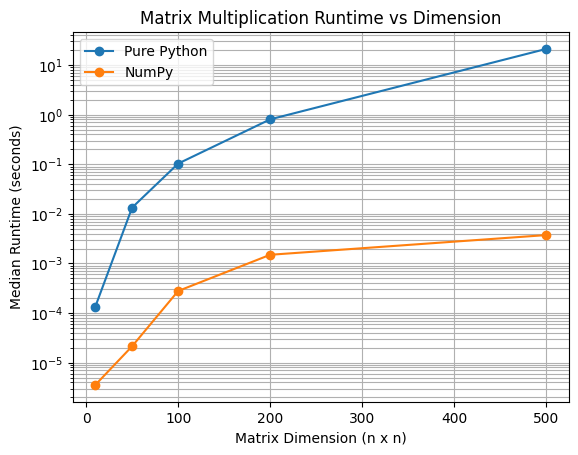

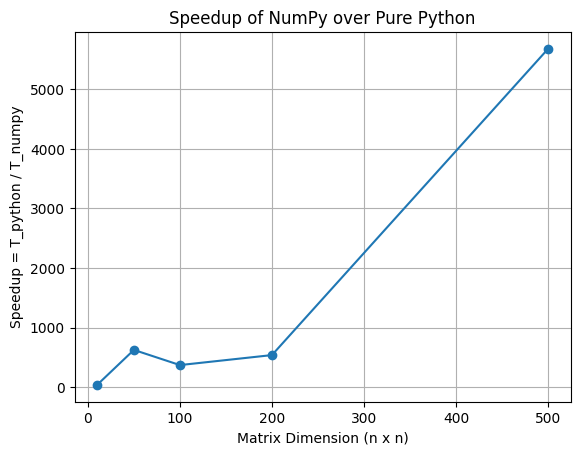

In [1]:
import time
import random
import statistics as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Configuration
# -----------------------------

SEED = 12345
random.seed(SEED)
np.random.seed(SEED)

DTYPE = np.float64

VECTOR_SIZES = [10, 50, 100, 200, 500]
MATRIX_SIZES = [10, 50, 100, 200, 500]
TRIALS = 10


# -----------------------------
# Vector element-wise multiply
# -----------------------------

def py_vector_multiply(a, b):
    n = len(a)
    result = [0.0] * n
    for i in range(n):
        result[i] = a[i] * b[i]
    return result


# -----------------------------
# True matrix multiplication
# -----------------------------

def py_matrix_multiply(A, B):
    n = len(A)
    C = [[0.0] * n for _ in range(n)]

    for i in range(n):
        Ai = A[i]
        Ci = C[i]
        for k in range(n):
            aik = Ai[k]
            Bk = B[k]
            for j in range(n):
                Ci[j] += aik * Bk[j]

    return C


# -----------------------------
# Timing helper
# -----------------------------

def median_time(function, trials=TRIALS, warmup=True):
    if warmup:
        function()

    times = []
    for _ in range(trials):
        start = time.perf_counter()
        function()
        end = time.perf_counter()
        times.append(end - start)

    return stats.median(times)


# =============================
# VECTOR BENCHMARK
# =============================

print("\n--- VECTOR ELEMENT-WISE MULTIPLICATION ---")

vec_rows = []

for n in VECTOR_SIZES:

    # Creates arrays OUTSIDE timed region
    a_py = [float(random.random()) for _ in range(n)]
    b_py = [float(random.random()) for _ in range(n)]

    a_np = np.array(a_py, dtype=DTYPE)
    b_np = np.array(b_py, dtype=DTYPE)

    # Correctness verification
    out_py = py_vector_multiply(a_py, b_py) #Pure Python element-wise multiply
    out_np = a_np * b_np #Numpy's element-wise multiply
    assert np.allclose(np.array(out_py, dtype=DTYPE), out_np)

    # Timing only multiplication
    t_py = median_time(lambda: py_vector_multiply(a_py, b_py))
    t_np = median_time(lambda: a_np * b_np)

    speedup = t_py / t_np if t_np > 0 else float("nan")

    vec_rows.append({
        "n": n,
        "t_python_s": t_py,
        "t_numpy_s": t_np,
        "speedup": speedup
    })

    print(f"Size {n:4d} -> Python: {t_py:.6e}s | NumPy: {t_np:.6e}s | Speedup: {speedup:.2f}x")

df_vec = pd.DataFrame(vec_rows)


# =============================
# MATRIX BENCHMARK
# =============================

print("\n--- MATRIX MULTIPLICATION ---")

mat_rows = []

for n in MATRIX_SIZES:

    print(f"\nRunning {n}x{n}...")

    # Creates matrices OUTSIDE timed region
    A_py = [[float(random.random()) for _ in range(n)] for _ in range(n)]
    B_py = [[float(random.random()) for _ in range(n)] for _ in range(n)]

    A_np = np.array(A_py, dtype=DTYPE)
    B_np = np.array(B_py, dtype=DTYPE)

    # Correctness verification
    C_py = py_matrix_multiply(A_py, B_py) #Pure Python matrix multiplication
    C_np = A_np @ B_np #Numpy's matrix multiplication
    assert np.allclose(np.array(C_py, dtype=DTYPE), C_np)

    # Timing only multiplication
    t_py = median_time(lambda: py_matrix_multiply(A_py, B_py))
    t_np = median_time(lambda: A_np @ B_np)

    speedup = t_py / t_np if t_np > 0 else float("nan")

    mat_rows.append({
        "n": n,
        "t_python_s": t_py,
        "t_numpy_s": t_np,
        "speedup": speedup
    })

    print(f"Size {n:4d}x{n:4d} -> Python: {t_py:.6e}s | NumPy: {t_np:.6e}s | Speedup: {speedup:.2f}x")

df_mat = pd.DataFrame(mat_rows)


# =============================
# RESULTS TABLES
# =============================

print("\nVector Results:")
print(df_vec.to_string(index=False))

print("\nMatrix Results:")
print(df_mat.to_string(index=False))


# =============================
# REQUIRED PLOT
# =============================

plt.figure()
plt.plot(df_mat["n"], df_mat["t_python_s"], marker="o", label="Pure Python")
plt.plot(df_mat["n"], df_mat["t_numpy_s"], marker="o", label="NumPy")
plt.xlabel("Matrix Dimension (n x n)")
plt.ylabel("Median Runtime (seconds)")
plt.title("Matrix Multiplication Runtime vs Dimension")
plt.yscale("log")
plt.grid(True, which="both")
plt.legend()
plt.show()


# =============================
# OPTIONAL SPEEDUP PLOT
# =============================

plt.figure()
plt.plot(df_mat["n"], df_mat["speedup"], marker="o")
plt.xlabel("Matrix Dimension (n x n)")
plt.ylabel("Speedup = T_python / T_numpy")
plt.title("Speedup of NumPy over Pure Python")
plt.grid(True, which="both")
plt.show()